In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import subprocess
from tqdm import tqdm
from multiprocessing import Process
os.chdir("/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark")

In [3]:
train_command = """python main.py train iit -i {task} --same-size -s {strict_weight} -iit {iit_weight} -o results_same_size"""
acdc_command = """python main.py run acdc -i {task} --load-from-wandb -w {siit_weight} -t {threshold} -o results_same_size"""
eval_command = """python main.py eval node_realism -i {task} --same-size -w {siit_weight} -t {threshold} --relative 1 -o results_same_size"""

# tasks = ['3', '4', '11', '20', '34']
s = 0.5
siit_weight = "510"
iit_weight = "110"
# for task in tqdm(tasks):
#     siit_train_command = train_command.format(task=task, strict_weight=s, iit_weight=1)
#     iit_train_command = train_command.format(task=task, strict_weight=0, iit_weight=1)
#     natural_train_command = train_command.format(task=task, strict_weight=0, iit_weight=0)

#     # run all the training commands parallelly and wait for them to finish
#     processes = []
#     for c in [siit_train_command, iit_train_command, natural_train_command]:
#         print(f"Running command {c.split(' ')}")
#         # run silently
#         p = subprocess.Popen(c.split(' '), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#         processes.append(p)

#     for p in processes:
#         p.wait()

In [48]:
from circuits_benchmark.utils.ll_model_loader.best_weights import get_best_weight
thresholds = [0.0, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1, 2.5, 5, 10, 25, 50, 100]
tasks = ['11', '35']
# thresholds = [0.01]
for task in tqdm(tasks):
    siit_weight = get_best_weight(task)
    for t in thresholds:
        print("-"*50)
        print(f"Running task {task} with threshold {t}")
        siit_acdc_command = acdc_command.format(task=task, siit_weight=siit_weight, threshold=t)
        iit_acdc_command = acdc_command.format(task=task, siit_weight=iit_weight, threshold=t)
        natural_acdc_command = acdc_command.format(task=task, siit_weight=0, threshold=t) + " --natural"
        tracr_acdc_command = acdc_command.format(task=task, siit_weight=siit_weight, threshold=t) + " --tracr"

        # run all the acdc commands
        processes = []
        for c in [siit_acdc_command, iit_acdc_command, natural_acdc_command, tracr_acdc_command]:
            print(f"Running command {c.split(' ')}")
            p = subprocess.Popen(c.split(' '), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            processes.append(p)
            
        for p in processes:
            p.wait()
        siit_eval_command = eval_command.format(task=task, siit_weight=siit_weight, threshold=t)
        iit_eval_command = eval_command.format(task=task, siit_weight=iit_weight, threshold=t)
        natural_eval_command = eval_command.format(task=task, siit_weight=0, threshold=t) + " --natural"
        tracr_eval_command = eval_command.format(task=task, siit_weight=siit_weight, threshold=t) + " --tracr"

        # run all the eval commands without waiting for them to finish
        for c in [siit_eval_command, iit_eval_command, natural_eval_command, tracr_eval_command]:
            print(f"Running command {c}")
            p = subprocess.Popen(c.split(' '), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            processes.append(p)
            # p.wait()
        
        for p in processes:
            p.wait()

Running command python main.py eval node_realism -i 35 --same-size -w 1110 -t 0.01 --relative 1 -o results_same_size
Running command python main.py eval node_realism -i 35 --same-size -w 110 -t 0.01 --relative 1 -o results_same_size
Running command python main.py eval node_realism -i 35 --same-size -w 0 -t 0.01 --relative 1 -o results_same_size --natural
Running command python main.py eval node_realism -i 35 --same-size -w 1110 -t 0.01 --relative 1 -o results_same_size --tracr
--------------------------------------------------
Running task 35 with threshold 0.025
Running command ['python', 'main.py', 'run', 'acdc', '-i', '35', '--load-from-wandb', '-w', '1110', '-t', '0.025', '-o', 'results_same_size']
Running command ['python', 'main.py', 'run', 'acdc', '-i', '35', '--load-from-wandb', '-w', '110', '-t', '0.025', '-o', 'results_same_size']
Running command ['python', 'main.py', 'run', 'acdc', '-i', '35', '--load-from-wandb', '-w', '0', '-t', '0.025', '-o', 'results_same_size', '--natur

100%|██████████| 2/2 [08:25<00:00, 252.84s/it]


In [49]:
import numpy as np

tasks = [3, 4, 11, 35]
confusion_matrices = np.zeros((len(tasks), 4, 4))

for task_num, task in enumerate(tasks):
    try:
        iit_results = [
            (float(s.split(", ")[0]), float(s.split(", ")[1].strip("\n")))
            for s in open(f"results_same_size/realism/{task}_iit_score.txt", "r").readlines()
        ]
        siit_results =[
            (float(s.split(", ")[0]), float(s.split(", ")[1].strip("\n")))
            for s in open(f"results_same_size/realism/{task}_siit_score.txt", "r").readlines()
        ]
        tracr_results = [
            (float(s.split(", ")[0]), float(s.split(", ")[1].strip("\n")))
            for s in open(f"results_same_size/realism/{task}_tracr_score.txt", "r").readlines()
        ]
        natural_results = [
            (float(s.split(", ")[0]), float(s.split(", ")[1].strip("\n")))
            for s in open(f"results_same_size/realism/{task}_natural_score.txt", "r").readlines()
        ]
    except:
        print(f"Task {task} does not have results for all methods")
        continue
    ls = [len(iit_results), len(siit_results), len(tracr_results), len(natural_results)]
    if min(ls) != max(ls):
        print(f"Task {task} has different number of results for different methods")
        continue
    iit_results = np.array(iit_results)[:, 1]
    siit_results = np.array(siit_results)[:, 1]
    tracr_results = np.array(tracr_results)[:, 1]
    natural_results = np.array(natural_results)[:, 1]

    confusion_matrix = np.zeros((4, 4))
    results = [natural_results, tracr_results, siit_results, iit_results]
    for i, r in enumerate(results):
        for j, r2 in enumerate(results):
            confusion_matrix[i, j] = np.corrcoef(r, r2)[0, 1]
    confusion_matrices[task_num] = confusion_matrix

Task 35 does not have results for all methods


In [57]:
# remove confusion matrices with all zeros
confusion_matrices = confusion_matrices[~np.all(confusion_matrices == 0, axis=(1, 2))]
confusion_matrices.shape

(3, 4, 4)

In [58]:
import pandas as pd

def make_df(confusion_matrix):
    df = pd.DataFrame(confusion_matrix, columns=["Natural", "Tracr", "SIIT", "IIT"], index=["Natural", "Tracr", "SIIT", "IIT"]).round(2)
    # make top triangle of confusion matrix 0
    df = df.where(np.tril(np.ones(df.shape)).astype(bool))
    return df
make_df(confusion_matrices[0])

,Natural,Tracr,SIIT,IIT
Natural,1.00,NaN,NaN,NaN
Tracr,0.70,1.00,NaN,NaN
SIIT,0.95,0.65,1.00,NaN
IIT,0.83,0.66,0.75,1.0


In [59]:
confusion_matrices

array([[[1.        , 0.69718748, 0.94545063, 0.82857689],
        [0.69718748, 1.        , 0.64526228, 0.66485594],
        [0.94545063, 0.64526228, 1.        , 0.74898615],
        [0.82857689, 0.66485594, 0.74898615, 1.        ]],

       [[1.        , 0.61280262, 0.90472976, 0.95022405],
        [0.61280262, 1.        , 0.84369661, 0.66076235],
        [0.90472976, 0.84369661, 1.        , 0.95867848],
        [0.95022405, 0.66076235, 0.95867848, 1.        ]],

       [[1.        , 0.38924947, 0.54282985, 0.78878437],
        [0.38924947, 1.        , 0.42491083, 0.34602818],
        [0.54282985, 0.42491083, 1.        , 0.65909558],
        [0.78878437, 0.34602818, 0.65909558, 1.        ]]])

In [60]:
df = make_df(confusion_matrices.mean(axis=0))
df

,Natural,Tracr,SIIT,IIT
Natural,1.00,NaN,NaN,NaN
Tracr,0.57,1.00,NaN,NaN
SIIT,0.80,0.64,1.00,NaN
IIT,0.86,0.56,0.79,1.0


In [61]:
print(df.to_latex(
    float_format="%.2f",
    na_rep="-",
))

\begin{tabular}{lrrrr}
\toprule
 & Natural & Tracr & SIIT & IIT \\
\midrule
Natural & 1.00 & - & - & - \\
Tracr & 0.57 & 1.00 & - & - \\
SIIT & 0.80 & 0.64 & 1.00 & - \\
IIT & 0.86 & 0.56 & 0.79 & 1.00 \\
\bottomrule
\end{tabular}



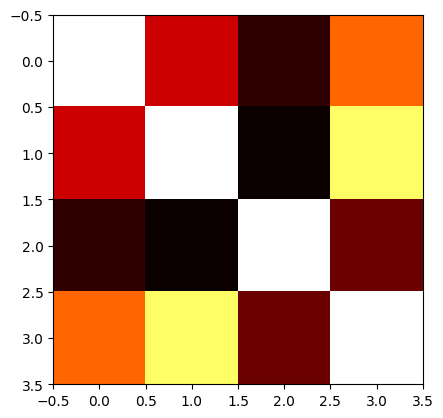

In [34]:
import plotly as px

